# NLP Disaster Tweets Kaggle Mini-Project (Week 4 Peer-Graded Assignment

## PROBLEM DESCRIPTION

This mini-project is part of a Kaggle competition, where the main goal is to identify public tweets from Twitter that are about real disasters as well as tweets that are not (all of which is part of a selected dataset). The given dataset is in the form of three CSV files: a training data file, a test data file, and a sample submissions file. The training data file includes the following features: id, keyword, location, text, and target. The test data file includes the same features with the exception of the 'target' feature, which is what we are responsible for predicting and submitting the results to Kaggle. Below is the initial code for reading and viewing datasets. Below is also a link to the Kaggle challenge and datasets as well as a Github link to access content related to this mini-project.


Kaggle Link and Data Source: https://www.kaggle.com/c/nlp-getting-started/overview

Github Repoistory Link for Project Content: https://github.com/IsraelsLibrary/DTSA_5511_NLP_Disaster_Tweets_Kaggle_MiniProject

In [1]:
# Importing required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from wordcloud import WordCloud

In [2]:
# Reading in data from the training and test files

training_data = "data/train.csv"
test_data = "data/test.csv"


if os.path.exists(training_data):
    # Open and read the file
    with open(training_data, 'r') as file:
        train_data = pd.read_csv(file)
        file.close()
else:
    print(f"The file {training_data} does not exist in the specified folder.")
    
    
if os.path.exists(test_data):
    # Open and read the file
    with open(test_data, 'r') as file:
        test_data = pd.read_csv(file)
        file.close()
else:
    print(f"The file {test_data} does not exist in the specified folder.")

In [3]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## EXPLORATORY DATA ANALYSIS

Upon further investigation, the total amount of data had the following split between training and test datasets: the training set accounts for 70% of the total data whereas the test data included 30% of the total amount. The training data contains 7,613 observations as the test data contains 3,263 observations. 

At first glance of both datasets, there is a very noticeable characteristic: there were features in both datasets that had multiple missing values. However, there is consistency in which features have missing values in both datasets. For both datasets, the common features that contain missing values are 'keyword' and 'location'. In terms of cleaning the data, I decided to remove the features with missing entries altogether, so that the main features to focus on are 'id' and 'text'.

After cleaning the data, I generated data visualizations to observe other aspects of the given dataset. For the first visualization, I generate a word cloud plot, with the goal of identifying the frequency of certain terms and words that appear across the given data messages. I discovered that terms such as 'fire', 'burning', and 'death' appear frequently, which can have relevance to distinguishing disaster-related tweets from tweets not about disasters. For the second visualization, I create a histogram that tracks the frequency of different message lengths for given tweet messages. From the second visualization, I found that the highest number of tweets within the given dataset were found to be roughly between 135 and 143 characters long.  This information will be helpful when it comes to creating word embeddings for each tweet and further transforming the data in preparation for model training.

For this use case, I will be using both a long short-term memory (LSTM) model and a gated recurrent unit (GRU) model to train the data with, and make a comparative analysis to see which model performs better in this case.

In [5]:
# Reviewing features in the training dataset and seeing which features
# contain null values

train_data.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [6]:
# Helper function for cleaning the data
def clean_data(table):
    for col in table.columns:
        if table[col].isnull().sum()>0:
            table = table.drop(col, axis=1)
    return table

In [7]:
df = clean_data(train_data)
df

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


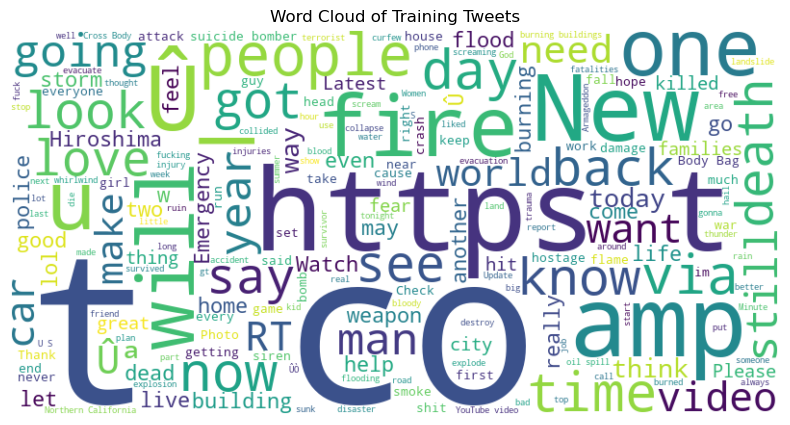

In [8]:
# Combine all tweet messages into a single string
all_train_tweets = ' '.join(train_data['text'].astype(str))


# Generate a word cloud for the training data
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(all_train_tweets)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Training Tweets')
plt.show()

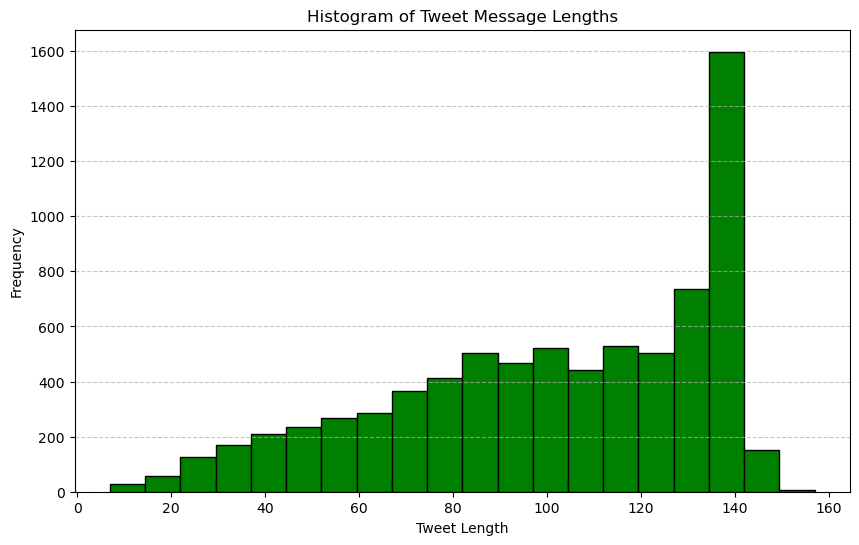

In [11]:
# Calculate tweet lengths and add a new column to the DataFrame
train_data['tweet_length'] = train_data['text'].apply(len)

# Create a histogram of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(train_data['tweet_length'], bins=20, color='green', edgecolor='black')
plt.title('Histogram of Tweet Message Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## LONG SHORT-TERM MEMORY (LSTM) MODEL AND ARCHITECTURE

For this initial model setup, I develop a separate class to represent the LSTM model (in order to simplify the process of modifying hyperparameters). For the infrastructure, the first layer is an embedding layer to handle the processed input data (converts the inputs into vectors of a fixed dimesion size). Following the embedding layer, we next have the bidirectional LSTM layer to process the embedded sequence and capture more context information. Lastly, I add a Dense layer with a sigmoid activation function, which generates probability scores between 0 and 1 for a given input. Once all layers are added to a created model, the code compiles the model with a specified optimizer, loss function type, and desired metrics. I incorporated a similar architecture for the GRU model detailed below  with some minor differences. 

In [12]:
# Libraries for Model Creation, Training, and Evaluation
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import precision_score, recall_score, f1_score

In [13]:
# Class Representation for the LSTM Model:

class custom_LSTM():
    def __init__(self, vocab_size, max_seq_length, embedding_dim, dropout, units, optimizer='adam'):
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.units = units
        self.optimizer = optimizer
        self.model = Sequential()
        
    def forward(self):
        self.model.add(layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,
                                input_length=self.max_seq_length))
        self.model.add(Bidirectional(LSTM(units=self.units, activation='tanh', dropout=self.dropout)))
        self.model.add(layers.Dense(units=1, activation='sigmoid'))
        
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        return self.model

## INITIAL MODEL TRAINING  (LSTM MODEL)

I use the TfidfVectorizer library to preprocess the input data before applying it to the LSTM model for training. For initial training purposes, I set the number of epochs to 7 and batch size to 30. As a result, the model did not train that well, so further experimentation was needed to make sure the LSTM model is working properly.

In [14]:
# Reading in libraries and preprocessing the input data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

X_train = train_data['text'].astype(str).tolist()
labels = train_data['target'].tolist()


X_train, X_val, y_train, y_val = train_test_split(X_train, labels, test_size=0.2, random_state=22)


# Feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)



Epoch 1/7
203/203 [==============================] - 1017s 5s/step - loss: 0.6860 - accuracy: 0.5654 - val_loss: 0.6786 - val_accuracy: 0.5863
Epoch 2/7
203/203 [==============================] - 1032s 5s/step - loss: 0.6850 - accuracy: 0.5663 - val_loss: 0.6806 - val_accuracy: 0.5863
Epoch 3/7
203/203 [==============================] - 1047s 5s/step - loss: 0.6850 - accuracy: 0.5663 - val_loss: 0.6797 - val_accuracy: 0.5863
Epoch 4/7
203/203 [==============================] - 1004s 5s/step - loss: 0.6847 - accuracy: 0.5663 - val_loss: 0.6802 - val_accuracy: 0.5863
Epoch 5/7
203/203 [==============================] - 974s 5s/step - loss: 0.6850 - accuracy: 0.5663 - val_loss: 0.6794 - val_accuracy: 0.5863
Epoch 6/7
203/203 [==============================] - 969s 5s/step - loss: 0.6847 - accuracy: 0.5663 - val_loss: 0.6784 - val_accuracy: 0.5863
Epoch 7/7
203/203 [==============================] - 1089s 5s/step - loss: 0.6848 - accuracy: 0.5663 - val_loss: 0.6788 - val_accuracy: 0.5863


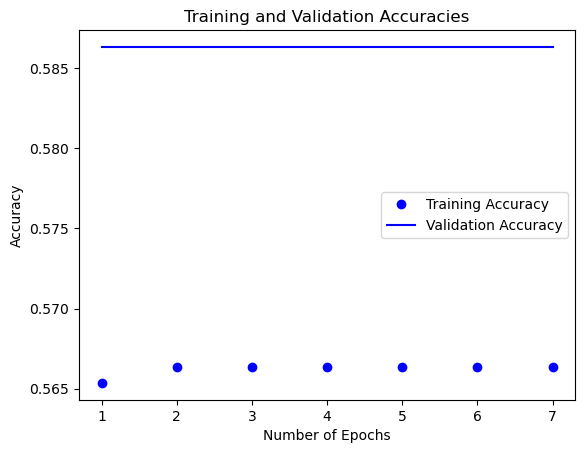

In [15]:
# Testing the LSTM model with transformed inputs

vocab_size = X_train_tfidf.shape[1]
max_seq_length = X_train_tfidf.shape[1]
embedding_dim = 256
dropout = 0.5
units = 64

model = custom_LSTM(vocab_size=vocab_size, max_seq_length=max_seq_length, embedding_dim=embedding_dim, units=units, dropout=dropout)
LSTM_model = model.forward()

y_train = np.array(y_train)
y_val = np.array(y_val)
history = LSTM_model.fit(X_train_tfidf.toarray(), y_train, epochs=7, batch_size=30, validation_data=(X_val_tfidf.toarray(), y_val))

# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()

## MODIFYING THE INPUT SEQUENCES

After further experimenation, it appeared that using a different method to preprocess the input data greatly improved the performance of the LSTM model. Instead of using the TfidfVectorizer, I applied a Tokenizer to process the inputs, as shown below. This improved the model accuracy, with results leading to a training accuracy of 98% and validation accuracy of 79.5% for the LSTM model.

In [16]:
# Preprocess Training Data
X_train = train_data['text'].astype(str)
y_train = train_data['target']

X_test = test_data['text'].astype(str)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)

# Convert text to sequences
max_seq_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')


# Tokenize the text
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_test)

# Convert text to sequences
X_test_sequences = tokenizer2.texts_to_sequences(X_test)

# Pad sequences to a fixed length
max_seq_length2 = max(len(seq) for seq in X_test_sequences)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

# Train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=22
)




In [18]:
from keras.callbacks import EarlyStopping
# Test
vocab_size = len(tokenizer.word_index) + 1
max_seq_length = X_train_padded.shape[1]
embedding_dim = 256
dropout = 0.5
units = 64

model = custom_LSTM(vocab_size=vocab_size, max_seq_length=max_seq_length, embedding_dim=embedding_dim, units=units, dropout=dropout)
LSTM_model = model.forward()

#LSTM_model.summary()
y_train = np.array(y_train)
y_val = np.array(y_val)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = LSTM_model.fit(X_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(X_val_split, y_val_split),
                        callbacks=[early_stopping])


# Print out the training accuracy
training_accuracy = history.history['accuracy']
print("Training Accuracy:", training_accuracy[-1])
# Evaluate your model on the validation set
validation_accuracy = LSTM_model.evaluate(X_val_split, y_val_split)
print("Validation Accuracy:", validation_accuracy[1])

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy if the training cycles meets the max number of epochs without stopping early
if len(epochs)==10:
    plt.plot(epochs, train_accuracy, 'ms', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g^', label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Display the plot
    plt.show()


Epoch 1/10
191/191 [==============================] - 15s 69ms/step - loss: 0.5356 - accuracy: 0.7310 - val_loss: 0.4462 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 13s 69ms/step - loss: 0.2974 - accuracy: 0.8839 - val_loss: 0.4851 - val_accuracy: 0.7912
Epoch 3/10
191/191 [==============================] - 14s 73ms/step - loss: 0.1496 - accuracy: 0.9443 - val_loss: 0.6041 - val_accuracy: 0.7603
Epoch 4/10
191/191 [==============================] - 13s 67ms/step - loss: 0.0613 - accuracy: 0.9805 - val_loss: 1.1964 - val_accuracy: 0.6967
Training Accuracy: 0.9804597496986389
48/48 [==============================] - 1s 11ms/step - loss: 0.4462 - accuracy: 0.7958
Validation Accuracy: 0.7957977652549744


## GATED RECURRENT UNIT (GRU) MODEL AND ARCHITECTURE

Like the LSTM, I set up a separate class representation for the GRU model. The main difference here is that I add additional layers to the GRU model to help reduce any potential overfitting, as indicated in the LSTM model (3 dropout layers and a batch normalization layer). The model also includes an embedding layer for inputs, 2 bidirectional GRU layers, and 2 Dense layers with respective activation functions. Also, like the LSTM, the GRU model compiles with user-specified hyperparameters. For inital testing purposes, the GRU model is trained with the same tokenized input data and hyperparameters as the LSTM model. 

In [19]:
# GRU Model:

class custom_GRU():
    def __init__(self, vocab_size, max_seq_length, embedding_dim, dropout, units, learning_rate=None, optimizer='adam'):
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.units = units
        self.optimizer = optimizer
        self.learning_rate=learning_rate
        self.model = Sequential()
        
    def forward(self):
        self.model.add(layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,
                                        input_length=self.max_seq_length))
        self.model.add(Bidirectional(GRU(units=self.units, dropout=self.dropout, recurrent_dropout=0.2, return_sequences=True)))
        self.model.add(Dropout(0.5))
        self.model.add(Bidirectional(GRU(units=self.units, dropout=self.dropout, recurrent_dropout=0.2)))
        self.model.add(Dropout(0.5))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Dense(units=128, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(layers.Dense(units=1, activation='sigmoid'))

        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        return self.model
            
            
            

## MODEL TRAINING  (GRU MODEL)

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Embedding, Dense

# Assuming 'df_train' is your training data and 'df_test' is your test data

# Preprocess Training Data
X_train = train_data['text'].astype(str)
y_train = train_data['target']

X_test = test_data['text'].astype(str)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)

# Convert text to sequences
max_seq_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')


# Tokenize the text
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_test)

# Convert text to sequences
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to a fixed length
max_seq_length2 = max(len(seq) for seq in X_test_sequences)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

# Train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=22
)


vocab_size = len(tokenizer.word_index) + 1
max_seq_length = X_train_padded.shape[1]
embedding_dim = 256
dropout = 0.5
units = 64

model = custom_GRU(vocab_size=vocab_size, max_seq_length=max_seq_length, embedding_dim=embedding_dim, units=units, dropout=dropout)
GRU_model = model.forward()


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = GRU_model.fit(X_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(X_val_split, y_val_split),
                       callbacks=[early_stopping])

# Print out the training accuracy
training_accuracy = history.history['accuracy']
print("Training Accuracy:", training_accuracy[-1])
# Evaluate your model on the validation set
validation_accuracy = LSTM_model.evaluate(X_val_split, y_val_split)
print("Validation Accuracy:", validation_accuracy[1])

# Plotting accuracy if the training cycles meets the max number of epochs without stopping early
if len(epochs)==10:
    plt.plot(epochs, train_accuracy, 'ms', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g^', label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Display the plot
    plt.show()


Epoch 1/10
191/191 [==============================] - 36s 162ms/step - loss: 0.6895 - accuracy: 0.6210 - val_loss: 0.5289 - val_accuracy: 0.7630
Epoch 2/10
191/191 [==============================] - 36s 190ms/step - loss: 0.4031 - accuracy: 0.8264 - val_loss: 0.5530 - val_accuracy: 0.7610
Epoch 3/10
191/191 [==============================] - 36s 189ms/step - loss: 0.2260 - accuracy: 0.9159 - val_loss: 0.6245 - val_accuracy: 0.7768
Epoch 4/10
191/191 [==============================] - 36s 188ms/step - loss: 0.1404 - accuracy: 0.9534 - val_loss: 0.7858 - val_accuracy: 0.7617
Training Accuracy: 0.9533661603927612
48/48 [==============================] - 1s 12ms/step - loss: 0.4462 - accuracy: 0.7958
Validation Accuracy: 0.7957977652549744


After training both the LSTM and GRU models with some initial tests, I found that both models provided similar performance and fairly high accuracies with the same input data and hyperparameters, as indicated by their validation accuracies. Since the validation accuracies were similar between both models, the next metric to monitor was the training accuracy to see how well both models were learning the data between epochs. Since the LSTM model resulted in a slightly higher training accuracy, I decided that I would proceed further with the LSTM model as my main model.

## OPTIMIZING THE LSTM MODEL AND TUNING HYPERPARAMETERS

The next step after model selection is to optimize the model performance. For further optimization, I included an additional dropout layer to reduce overfitting, and I also incorporated a learning rate. After these changes, the LSTM performed slightly better with the same input data, achieving a training accuracy of ?? and validation accuracy of ??. By the end of the training process, the final hyperparameters are as follows: 

1.) embedding dimension size of 128 <br> 
2.) dropout rate of 0.5 <br> 
3.) LSTM units value of 64 <br>
4.) An Adam optimizer with a learning rate value of 0.001.

In [21]:
class custom_LSTM():
    def __init__(self, vocab_size, max_seq_length, embedding_dim, dropout, units, optimizer='adam'):
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.units = units
        self.optimizer = optimizer
        self.model = Sequential()
        
    def forward(self):
        self.model.add(layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,
                                input_length=self.max_seq_length))
        self.model.add(Bidirectional(LSTM(units=self.units, activation='tanh', dropout=self.dropout)))
        if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))
        self.model.add(layers.Dense(units=1, activation='sigmoid'))
        
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        return self.model

In [24]:
from keras.optimizers.legacy import Adam

vocab_size = len(tokenizer.word_index) + 1
max_seq_length = X_train_padded.shape[1]
embedding_dim = 128
dropout = 0.5
units = 64
optimizer = Adam(learning_rate=0.001)


model = custom_LSTM(vocab_size=vocab_size, max_seq_length=max_seq_length, embedding_dim=embedding_dim, units=units, dropout=dropout,
                    optimizer=optimizer)
LSTM_model = model.forward()

#LSTM_model.summary()
y_train = np.array(y_train)
y_val = np.array(y_val)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = LSTM_model.fit(X_train_split, y_train_split, epochs=20, batch_size=16, validation_data=(X_val_split, y_val_split))


# Print out the training accuracy
training_accuracy = history.history['accuracy']
print("Training Accuracy:", training_accuracy[-1])
# Evaluate your model on the validation set
validation_accuracy = LSTM_model.evaluate(X_val_split, y_val_split)
print("Validation Accuracy:", validation_accuracy[1])

Epoch 1/20
381/381 [==============================] - 11s 23ms/step - loss: 0.5383 - accuracy: 0.7312 - val_loss: 0.4545 - val_accuracy: 0.7951
Epoch 2/20
381/381 [==============================] - 9s 23ms/step - loss: 0.3155 - accuracy: 0.8777 - val_loss: 0.4784 - val_accuracy: 0.7965
Epoch 3/20
381/381 [==============================] - 9s 23ms/step - loss: 0.1717 - accuracy: 0.9378 - val_loss: 0.6107 - val_accuracy: 0.7886
Epoch 4/20
381/381 [==============================] - 9s 24ms/step - loss: 0.0817 - accuracy: 0.9701 - val_loss: 0.8242 - val_accuracy: 0.7636
Epoch 5/20
381/381 [==============================] - 9s 23ms/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 1.0440 - val_accuracy: 0.7636
Epoch 6/20
381/381 [==============================] - 9s 23ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 1.1160 - val_accuracy: 0.7052
Epoch 7/20
381/381 [==============================] - 9s 22ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 1.3746 - val_accuracy: 0.673

## EVALUATION METRICS AND RESULTS

Since the data source does not include a set of test labels for the further testing, I generated a confusion matrix to keep track of true and false positives. Upon further observation, the number of true/false positives and negatives are as follows: <br>

True Positives: 625 <br>
False Positives: 268 <br>
True Negatives: 190 <br>
False Negatives: 440 <br>

One concern here is the high number of false negatives, which impacts the overall accuracy. After further calculations, additional metrics are found for the following: <br>

Accuracy: 0.535<br>
Precision: 0.699 <br>
Recall: 0.586 <br>
F1 Score: 0.638 <br>


Overall, the model seems to be performing fairly well in learning the data. However, there still remains a major discrepancy between the training accuracy and validation accuracy, which indicates that overfitting is still occurring. With more time and further optimization, I can achieve a higher validation accuracy for the model.


102/102 [==============================] - 1s 4ms/step


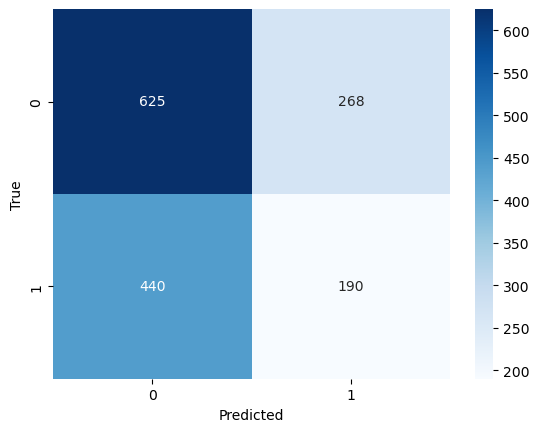

In [25]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = LSTM_model.predict(X_test_padded)

# The predictions will be in the form of probabilities, you may need to convert them to binary (0 or 1) based on a threshold
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions_fitted = binary_predictions[:len(y_val_split)]


cm = confusion_matrix(y_val_split, binary_predictions_fitted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [27]:
# Using confusion matrix results to calculate accuracy, precision, recall, and F1-Score results

TP = 623
FP = 268
FN = 440
TN = 190

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * ((precision * recall) / (precision + recall))


print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

Accuracy: 0.534516765285996, Precision: 0.6992143658810326, Recall: 0.5860771401693321, F1 Score: 0.6376663254861822


## MODEL TEST RESULTS FOR KAGGLE COMPETITION SUBMISSION

The following code generates an output submission CSV file for the Kaggle competition, based on the results of the selected model.

In [28]:
ids = test_data['id'].astype(str)

ids = np.array(ids)

predicted_labels = binary_predictions.flatten()

data = {'id': ids, 'target': predicted_labels}

df = pd.DataFrame(data)

df.to_csv('NLP_Final_Submission_File.csv', index=False)

## DISCUSSION, LESSONS LEARNED, AND CONCLUSION

For the selected LSTM model, I was able to achieve a fairly high validation accuracy of 74%, despite the indicators of overfitting. Adding dropout layers, implementing a learning rate, and changing the tokenization method for inputs proved to be highly effective during the optimization process and in improving model performance. From the initial training process, I learned that both the LSTM and GRU had similar performances against the training data. This indicates that either model would have been good options to leverage for this use case. With additional time, further optimizations can be made to further reduce overfitting, achieve a higher model accuracy, and explore other RNNs to see if they achieve the same (if not a better) outcome. 